# Drug–Target Interaction Prediction

![](https://github.com/pykale/mmai-tutorials/blob/main/tutorials/drug-target-interaction/images/drugban-pyakle-api.png?raw=1)


In this tutorial, we will train models to predict the interaction between **two data modalities**: **molecules (drug)** and **proteins (target)** using `PyKale`. Drug-target interaction (DTI) plays a key role in drug discovery and identifying potential therapeutic targets. This example is based on the **DrugBAN** framework by [**Bai et al. (_Nature Machine Intelligence_, 2023)**](https://www.nature.com/articles/s42256-022-00605-1).

The DTI prediction problem is formulated as a **binary classification task**, where the goal is to predict whether a given **drug–protein pair interacts or not**. The DrugBAN framework tackles this problem using two key ideas:

- **Bilinear Attention Network (BAN)**, which learns detailed feature representations for both drugs and proteins and captures local interaction patterns between them.

- **Adversarial Domain Adaptation**, which helps the model generalise to out-of-distribution datasets, i.e., in clustering-based cross-validation instead of random splits, improving its ability to predict interactions on unseen drug–target pairs.

With `PyKale`, implementing such a multimodal DTI prediction pipeline is straightforward. The library provides ready-to-use modules and configuration support, making it easy to apply advanced techniques with minimal custom coding.

## Step 0: Environment Preparation

As a starting point, we will install the required packages and load a set of helper functions to assist throughout this tutorial.

To prepare the helper functions and necessary materials, we download them from the GitHub repository.

Moreover, we provide helper functions that can be inspected directly in the `.py` files located in the notebook's current directory. The additional helper script is:
- [`config.py`](https://github.com/pykale/embc-mmai25/blob/main/tutorials/drug-target-interaction/configs.py): Defines the base configuration settings, which can be overridden using a custom `.yaml` file.

In [ ]:
import os

!rm -rf /content/mmai-tutorials
!git clone --single-branch -b main https://github.com/pykale/mmai-tutorials.git
%mv /content/mmai-tutorials/tutorials/drug-target-interaction /content/
%cd /content/drug-target-interaction

print("Changed working directory to:", os.getcwd())

Cloning into 'mmai-tutorials'...
remote: Enumerating objects: 610, done.
remote: Counting objects: 100% (242/242), done.
remote: Compressing objects: 100% (146/146), done.
remote: Total 610 (delta 156), reused 121 (delta 96), pack-reused 368 (from 2)
Receiving objects: 100% (610/610), 23.16 MiB | 16.03 MiB/s, done.
Resolving deltas: 100% (309/309), done.
mv: cannot move '/content/mmai-tutorials/tutorials/drug-target-interaction' to '/content/drug-target-interaction': Directory not empty
/content/drug-target-interaction
Changed working directory to: /content/drug-target-interaction


### Package Installation

The main package required for this tutorial is `PyKale`.

`PyKale` is an open-source interdisciplinary machine learning library developed at the University of Sheffield, with a focus on applications in biomedical and scientific domains.

Then, we install `PyG` (PyTorch Geometric) and related packages.

Please **do not** re-run this session after installation completed. Runing this installation multiple times will trigger issues related to `PyG`. If you want to re-run this installation, please click the `Runtime` on the top menu and choose `Disconnect and delete runtime` before installing.

In [ ]:
%pip install --quiet \
    "pykale[example]@git+https://github.com/pykale/pykale@main" \
    gdown==5.2.0 torch-geometric==2.6.0 torch_sparse torch_scatter \
    -f https://data.pyg.org/whl/torch-2.6.0+cu124.html \
    && echo "pykale, gdown, pyg and yacs installed successfully ✅" \
    || echo "Failed to install pykale, gdown, pyg and yacs ❌"

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
pykale, gdown, pyg and yacs installed successfully ✅


We then hide the warnings messages to get a clear output.

In [ ]:
import os
import warnings

warnings.filterwarnings("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"

Exercise: Check NumPy Version

In [ ]:
import numpy as np

print("NumPy version:", np.__version__)  # numpy should be 2.0.0 or higher

NumPy version: 2.0.2


### Configuration

To minimize the footprint of the notebook when specifying configurations, we provide a [`config.py`](https://github.com/pykale/embc-mmai25/blob/main/tutorials/drug-target-interaction/configs.py) file that defines default parameters. These can be customized by supplying a `.yaml` configuration file, such as [`configs/DA_cross_domain.yaml`](https://github.com/pykale/embc-mmai25/blob/main/tutorials/drug-target-interaction/configs/DA_cross_domain.yaml) as an example.

In [ ]:
from configs import get_cfg_defaults

%cd /content/drug-target-interaction

cfg = get_cfg_defaults()  # Load the default settings from config.py
cfg.merge_from_file(
    "configs/DA_cross_domain.yaml"
)  # Update (or override) some of those settings using a custom YAML file

/content/drug-target-interaction


In this tutorial, we list the hyperparameters we would like users to play with outside the `.yaml` file:
- `cfg.SOLVER.MAX_EPOCH`: Number of epochs in training stage. You can reduce the number of training epochs to shorten runtime.
- `cfg.DATA.DATASET`: The dataset used in the study. This can be `bindingdb` or `biosnap`.

As a quick exercise, please take a moment to review and understand the parameters in [`config.py`](https://github.com/pykale/embc-mmai25/blob/main/tutorials/drug-target-interaction/configs.py).

In [ ]:
cfg.SOLVER.MAX_EPOCH = 2

You can also switch to a different dataset.

In [ ]:
cfg.DATA.DATASET = "biosnap"

Exercise: Now print the full configuration to check all current hyperparameter and dataset settings.

In [ ]:
print(cfg)

BCN:
  HEADS: 2
COMET:
  API_KEY: 
  EXPERIMENT_NAME: DA_cross_domain
  PROJECT_NAME: drugban-23-May
  TAG: DrugBAN_CDAN
  USE: False
DA:
  INIT_EPOCH: 10
  LAMB_DA: 1
  METHOD: CDAN
  ORIGINAL_RANDOM: True
  RANDOM_DIM: 256
  RANDOM_LAYER: True
  TASK: True
  USE: True
  USE_ENTROPY: False
DATA:
  DATASET: biosnap
  SPLIT: cluster
DECODER:
  BINARY: 2
  HIDDEN_DIM: 512
  IN_DIM: 256
  NAME: MLP
  OUT_DIM: 128
DRUG:
  HIDDEN_LAYERS: [128, 128, 128]
  MAX_NODES: 290
  NODE_IN_EMBEDDING: 128
  NODE_IN_FEATS: 7
  PADDING: True
PROTEIN:
  EMBEDDING_DIM: 128
  KERNEL_SIZE: [3, 6, 9]
  NUM_FILTERS: [128, 128, 128]
  PADDING: True
RESULT:
  SAVE_MODEL: True
SOLVER:
  BATCH_SIZE: 32
  DA_LEARNING_RATE: 5e-05
  LEARNING_RATE: 0.0001
  MAX_EPOCH: 2
  NUM_WORKERS: 0
  SEED: 20


## Step 1: Data Loading and Preparation

In this tutorial, we use the **Biosnap** dataset for the main demonstration and the **BindingDB** dataset for the exercise at the end.

### Data Downloading

Please run the following cell to download necessary datasets.

In [ ]:
!rm -rf data
!mkdir data
!cd data

!pip install -q gdown
!gdown --id 1ogOcxZn-1q418LOT-gQ94aHQV0Y1sOmk --output data/drug-target-interaction.zip
!unzip data/drug-target-interaction.zip -d data/
!mv data/drug-target-interaction/checkpoint ./

Exercise: Check the data is ready

In [ ]:
import os
import shutil

print("Contents of the data folder:")
for item in os.listdir("data/drug-target-interaction"):
    print(item)

Contents of the data folder:
biosnap
bindingdb
checkpoint


The data content is structured as follows:
```sh
    ├───data
    │   ├───checkpoint
    │   ├───bindingdb
    │   ├───biosnap

The `data` folder contains two datasets: `bindingdb` and `biosnap`. Each dataset folder contains the following files. The `checkpoint` folder contains the saved model checkpoint, which are used later in the interpretation section.

In [ ]:
print("Contents of bindingdb folder:")
for item in os.listdir("data/drug-target-interaction/bindingdb"):
    print(item)

Contents of bindingdb folder:
random
full.csv
interpretation_samples.csv
cluster


Each dataset folder follows the structure:

```sh
    ├───dataset_name
    │   ├───cluster
    │   │   ├───source_train.csv
    │   │   ├───target_train.csv
    │   │   ├───target_test.csv
    │   ├───random
    │   │   ├───test.csv
    │   │   ├───train.csv
    │   │   ├───val.csv
    │   ├───full.csv
```

We use the cluster dataset folder for cross-domain prediction, containing three parts:

- Train samples from the source domain: Drug–protein pairs the model learns from.

- Train samples from the target domain: Additional training data from a different distribution to improve generalisation.

- Test samples from the target domain: Unseen drug–protein pairs used to evaluate model performance on new data.

The source and target sets are defined based on the clustering results.

### Data Loading

Here’s what each csv file looks like in a table format:

| SMILES             | Protein Sequence         | Y |
|--------------------|--------------------------|---|
| Fc1ccc(C2(COC…)    | MDNVLPVDSDLS…            | 1 |
| O=c1oc2c(O)c(…)    | MMYSKLLTLTTL…            | 0 |
| CC(C)Oc1cc(N…)     | MGMACLTMTEME…            | 1 |

Each row of the dataset contains three key pieces of information:

**Drugs**:  
Drugs are often written as SMILES strings, which are like chemical formulas in text format (for example, `"CC(=O)OC1=CC=CC=C1C(=O)O"` is aspirin).  


**Protein Sequence**  
This is a string of letters where each letter stands for an amino acid, the building blocks of proteins. For example, `MGYTSLLT...` is a short protein sequence.


**Y (Labels)**:  
Each drug–protein pair is given a label:
- `1` if they interact
- `0` if they do not


Each row shows one drug–protein pair. The goal of our machine learning model is to predict the last column (**Y**) — whether or not the drug and protein interact.

You can load CSV files into Python using tools like `pandas`. The output shows a sample of the data, including the SMILES string for the drug, the protein sequence, the interaction label (Y) and the cluster ID.

In [ ]:
import pandas as pd

dataFolder = os.path.join(
    f"data/drug-target-interaction/{cfg.DATA.DATASET}", str(cfg.DATA.SPLIT)
)

df_train_source = pd.read_csv(os.path.join(dataFolder, "source_train.csv"))
df_train_target = pd.read_csv(os.path.join(dataFolder, "target_train.csv"))
df_test_target = pd.read_csv(os.path.join(dataFolder, "target_test.csv"))

print("Sample example:", df_train_source.iloc[0])

Sample example: SMILES                              CC1=CN=C2N1C=CN=C2NCC1=CC=NC=C1
Protein           MARSLLLPLQILLLSLALETAGEEAQGDKIIDGAPCARGSHPWQVA...
Y                                                               0.0
drug_cluster                                                   1904
target_cluster                                                 1528
Name: 0, dtype: object


### Data Preprocessing

We convert drug SMILES strings into molecular graphs using `kale.loaddata.molecular_datasets.smiles_to_graph`, encoding atom-level features as node attributes and bond types as edges.


Protein sequences are transformed into fixed-length integer arrays using `kale.prepdata.chem_transform.integer_label_protein`, with each amino acid mapped to an integer and sequences padded or truncated to a uniform length.

Finally, the `kale.loaddata.molecular_datasets.DTIDataset` class packages drugs, proteins, and labels into a PyTorch-ready dataset.

**Note:** If you encounter an error related to requiring numpy `<2.0`, simply ignore it and re-run this block until it completes successfully.

In [ ]:
from kale.loaddata.molecular_datasets import DTIDataset

# Create preprocessed datasets
train_dataset = DTIDataset(df_train_source.index.values, df_train_source)
train_target_dataset = DTIDataset(df_train_target.index.values, df_train_target)
test_target_dataset = DTIDataset(df_test_target.index.values, df_test_target)

We load data in small, manageable pieces called batches to save memory and speed up training. We use `kale.loaddata.sampler.MultiDataLoader` from PyKale to load one batch from the source domain and one from the target domain at each training step.

First, we specify a few DataLoader parameters:
- Batch size: Number of samples per batch
- Shuffle: Randomly shuffle data
- Number of workers: Parallel data loading
- Drop last: Discard the last incomplete batch for consistent batch sizes
- Collate function: Use graph_collate_func to batch variable-sized molecular graphs

In [ ]:
from torch.utils.data import DataLoader
from kale.loaddata.molecular_datasets import graph_collate_func
from kale.loaddata.sampler import MultiDataLoader

params = {
    "batch_size": cfg.SOLVER.BATCH_SIZE,
    "shuffle": True,
    "num_workers": cfg.SOLVER.NUM_WORKERS,
    "drop_last": True,
    "collate_fn": graph_collate_func,
}

params

{'batch_size': 32,
 'shuffle': True,
 'num_workers': 0,
 'drop_last': True,
 'collate_fn': <function kale.loaddata.molecular_datasets.graph_collate_func(x)>}

Then, we create a DataLoader from both the source and target datasets for training.

In [ ]:
print("Using domain adaptation:", cfg.DA.USE)

if not cfg.DA.USE:
    training_generator = DataLoader(train_dataset, **params)
else:
    source_generator = DataLoader(train_dataset, **params)
    target_generator = DataLoader(train_target_dataset, **params)

    # Get the number of batches in the longer dataset to align both
    n_batches = max(len(source_generator), len(target_generator))

    # Combine the source and target data loaders using MultiDataLoader
    training_generator = MultiDataLoader(
        dataloaders=[source_generator, target_generator], n_batches=n_batches
    )

Using domain adaptation: True


Lastly, we set up DataLoaders for validation and testing. Since we don’t want to shuffle or drop any samples, we adjust the parameters accordingly.

In [ ]:
# Update parameters for validation/testing (no shuffling, keep all data)
params.update({"shuffle": False, "drop_last": False})

# Create validation and test data loaders
valid_generator = DataLoader(test_target_dataset, **params)
test_generator = DataLoader(test_target_dataset, **params)

### Exercise: Dataset Inspection

Once the dataset is ready, let’s inspect one sample from the training data to check the input graph, protein sequence, and label format.

In [ ]:
# Get the first batch (contains one batch from source and one from target)
first_batch = next(iter(training_generator))

# Unpack source and target batches
source_batch, target_batch = first_batch

# Inspect the first sample from the source batch
print("First sample from source batch:")
print("Drug graph:", source_batch[0][0])
print("Protein sequence:", source_batch[1][0])
print("Label:", source_batch[2][0])

First sample from source batch:
Drug graph: Data(x=[290, 7], edge_index=[2, 106], edge_attr=[106, 1], num_nodes=290)
Protein sequence: tensor([11.,  7., 18.,  ...,  0.,  0.,  0.], dtype=torch.float64)
Label: tensor(0., dtype=torch.float64)


This sample is a tuple with three parts:

1. **Drug Graph**
- `x=[290, 7]`: Feature matrix with 290 atoms (nodes) and 7 features per atom.
- `edge_index=[2, 58]`: Shows 146 edges, with source and target node indices.
- `edge_attr=[58, 1]`: Each edge has 1 bond feature, such as bond type.
- `num_nodes=290`: Confirms the graph has 290 nodes.

2. **Protein Features (array)**
- Example values: `[11.,  1., 18., ...,  0.,  0.,  0.]`: A fixed-length numeric array representing the protein sequence. Each position holds an integer-encoded amino acid, with zeros for padding.

3. **Label (float)**
- `0.0`; The ground-truth interaction label indicating no interaction.

## Step 2: Model Definition

### Embed

DrugBAN consists of three main components: a Graph Convolutional Network (GCN) for extracting structural features from drug molecular graphs, a Convolutional Neural Network (CNN) for encoding protein sequences, and a Bilinear Attention Network (BAN) for fusing drug and protein features. The fused representation is then passed through a Multi-Layer Perceptron (MLP) classifier to predict interaction scores.

We define the DrugBAN class in `kale.embed.ban`.

In [ ]:
from kale.embed.ban import DrugBAN

model = DrugBAN(**cfg)
print(model)

DrugBAN(
  (drug_extractor): MolecularGCN(
    (init_transform): Linear(in_features=7, out_features=128, bias=False)
    (gcn_layers): ModuleList(
      (0-2): 3 x GCNConv(128, 128)
    )
  )
  (protein_extractor): ProteinCNN(
    (embedding): Embedding(26, 128, padding_idx=0)
    (conv1): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(128, 128, kernel_size=(6,), stride=(1,))
    (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv1d(128, 128, kernel_size=(9,), stride=(1,))
    (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (bcn): BANLayer(
    (v_net): FCNet(
      (main): Sequential(
        (0): Dropout(p=0.2, inplace=False)
        (1): Linear(in_features=128, out_features=768, bias=True)
        (2): ReLU()
      )
    )
    (q_net): FCNet(
      (main): Sequential(
     

### Predict
We use the PyKale pipeline API `kale.pipeline.drugban_trainer` to connect dataloaders, encoders and outcoders for model training and evaluation.

In [ ]:
from kale.pipeline.drugban_trainer import DrugbanTrainer

drugban_trainer = DrugbanTrainer(
    model=DrugBAN(**cfg),
    solver_lr=cfg.SOLVER.LEARNING_RATE,
    num_classes=cfg.DECODER.BINARY,
    batch_size=cfg.SOLVER.BATCH_SIZE,
    is_da=cfg.DA.USE,
    solver_da_lr=cfg.SOLVER.DA_LEARNING_RATE,
    da_init_epoch=cfg.DA.INIT_EPOCH,
    da_method=cfg.DA.METHOD,
    original_random=cfg.DA.ORIGINAL_RANDOM,
    use_da_entropy=cfg.DA.USE_ENTROPY,
    da_random_layer=cfg.DA.RANDOM_LAYER,
    da_random_dim=cfg.DA.RANDOM_DIM,
    decoder_in_dim=cfg.DECODER.IN_DIM,
)

We want to save the best model during training so we can reuse it later without needing to retrain. PyTorch Lightning’s `ModelCheckpoint` does this by automatically saving the model whenever it achieves a new best validation AUROC score.

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    filename="{epoch}-{step}-{val_BinaryAUROC:.4f}",
    monitor="val_BinaryAUROC",
    mode="max",
)

We now create the `Trainer`.

In [ ]:
import torch

trainer = pl.Trainer(
    callbacks=[checkpoint_callback],
    devices="auto",
    accelerator="auto",
    max_epochs=cfg.SOLVER.MAX_EPOCH,
    deterministic=True,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


## Step 3: Model Training

### Train

After setting up the model and data loaders, we now start training the full DrugBAN model using the PyTorch Lightning Trainer via calling `trainer.fit()`.

#### What Happens Here?
- The model receives batches of drug-protein pairs from the training data loader.

- During each step, the GCN, CNN, BAN layer, and MLP classifier are updated to improve interaction prediction.

- Validation is automatically run at the end of each epoch to track performance and save the best model based on AUROC.


This code block takes approximately 5 minutes to complete.

In [ ]:
trainer.fit(
    drugban_trainer,
    train_dataloaders=training_generator,
    val_dataloaders=valid_generator,
)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                 | Type                | Params | Mode 
---------------------------------------------------------------------
0 | model                | DrugBAN             | 1.0 M  | train
1 | domain_discriminator | DomainNetSmallImage | 133 K  | train
2 | random_layer         | RandomLayer         | 66.0 K | train
3 | valid_metrics        | MetricCollection    | 0      | train
4 | test_metrics         | MetricCollection    | 0      | train
---------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.847     Total estimated model params size (MB)
64        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[18:07:56] Unusual charge on atom 0 number of radical electrons set to zero
[18:08:08] Unusual charge on atom 0 number of radical electrons set to zero


Validation: |          | 0/? [00:00<?, ?it/s]

[18:09:24] Unusual charge on atom 0 number of radical electrons set to zero
[18:10:07] Unusual charge on atom 0 number of radical electrons set to zero


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


## Step 4: Evaluation

Once training is complete, we evaluate the model on the test set using `trainer.test()`.

### What is included in this step?
- The best model checkpoint (based on validation AUROC) is automatically loaded.

- The model runs on the test data to generate predictions.

- Final classification metrics, including AUROC, F1 score, accuracy, sensitivity, and specificity, are calculated and logged.

In [ ]:
trainer.test(drugban_trainer, dataloaders=test_generator, ckpt_path="best")

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drug-target-interaction/lightning_logs/version_2/checkpoints/epoch=0-step=610-val_BinaryAUROC=0.4845.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drug-target-interaction/lightning_logs/version_2/checkpoints/epoch=0-step=610-val_BinaryAUROC=0.4845.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     test_BinaryAUROC      │    0.48449382185935974    │
│    test_BinaryAccuracy    │    0.5071665048599243     │
│    test_BinaryF1Score     │    0.0933062881231308     │
│     test_BinaryRecall     │   0.050549451261758804    │
│  test_BinarySpecificity   │    0.9668141603469849     │
│   test_accuracy_sklearn   │    0.5038588643074036     │
│    test_auroc_sklearn     │    0.48449382185935974    │
│      test_f1_sklearn      │    0.6671618223190308     │
│         test_loss         │    0.8901852369308472     │
│   test_optim_threshold    │    0.07649494707584381    │
│     test_sensitivity      │   0.006637168116867542    │
│     test_specificity      │     0.997802197933197     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.8901852369308472,
  'test_auroc_sklearn': 0.48449382185935974,
  'test_accuracy_sklearn': 0.5038588643074036,
  'test_f1_sklearn': 0.6671618223190308,
  'test_optim_threshold': 0.07649494707584381,
  'test_sensitivity': 0.006637168116867542,
  'test_specificity': 0.997802197933197,
  'test_BinaryAUROC': 0.48449382185935974,
  'test_BinaryF1Score': 0.0933062881231308,
  'test_BinaryRecall': 0.050549451261758804,
  'test_BinarySpecificity': 0.9668141603469849,
  'test_BinaryAccuracy': 0.5071665048599243}]

### Performance Comparison

The earlier example was a simple demonstration. To properly evaluate DrugBAN against baseline models, we train it for 100 epochs across multiple random seeds.

We provide a checkpoint trained for 100 epochs in the `checkpoint` for your test after the tutorial. We will also use the provided checkpoint for the interpretation section for a better visualization.


The figure below shows the performance of different models on the BioSNAP and BindingDB datasets:
- Left plot: AUROC (Area Under the ROC Curve)
- Right plot: AUPRC (Area Under the Precision–Recall Curve)

![](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs42256-022-00605-1/MediaObjects/42256_2022_605_Fig3_HTML.png?as=webp)

The box plots show the median as the centre lines and the mean as green triangles. The minima and lower percentile represent the worst and second-worst scores. The maxima and upper percentile indicate the best and second-best scores. Supplementary Table 2 provides the data statistics of the BindingDB and BioSNAP datasets.

## Step 5: Interpretation

We interpret the trained models by analyzing the learned attention weights. In this step, we will use PyKale's API to
1) draw the attention maps of the Bilinear Attention Network (BAN) layer, and
2) generate molecule images with attention highlights.

This helps us understand which parts of the drug contribute to the interaction with the target protein.

### Extracting Attention Weights
First, we need to load the test dataset and create a DataLoader for it. This will allow us to process the test samples in batches. We define functions to create the test dataset and DataLoader.

In [ ]:
def get_test_dataset(dataFolder):
    df_test_target = pd.read_csv(dataFolder)
    test_target_dataset = DTIDataset(df_test_target.index.values, df_test_target)
    return test_target_dataset


def get_test_dataloader(dataset, batchsize, num_workers, collate_fn):
    test_dataloader = DataLoader(
        dataset,
        batch_size=batchsize,
        num_workers=num_workers,
        collate_fn=collate_fn,
        shuffle=False,
        drop_last=True,
    )
    return test_dataloader

We load a small subset of samples for testing from the provided `.csv` file. You can create your own `.csv` file with the same format to test your drug–protein pairs.

In [ ]:
test_dataFolder = "/content/drug-target-interaction/data/drug-target-interaction/bindingdb/interpretation_samples.csv"

We then build the test dataset and DataLoader using the functions defined above. The `batchsize` is set to 1 to ensure we process one sample at a time for attention visualization later.

In [ ]:
test_dataset = get_test_dataset(test_dataFolder)
test_dataloader = get_test_dataloader(
    test_dataset,
    batchsize=1,
    num_workers=cfg.SOLVER.NUM_WORKERS,
    collate_fn=graph_collate_func,
)

Then, we use the following function to load the trained model with the PyKale API.

In [ ]:
def get_model_from_ckpt(ckpt_path, config):
    return DrugbanTrainer.load_from_checkpoint(
        checkpoint_path=ckpt_path,
        model=DrugBAN(**config),
        solver_lr=config.SOLVER.LEARNING_RATE,
        num_classes=config.DECODER.BINARY,
        batch_size=config.SOLVER.BATCH_SIZE,
        # --- domain adaptation parameters ---
        is_da=config.DA.USE,
        solver_da_lr=config.SOLVER.DA_LEARNING_RATE,
        da_init_epoch=config.DA.INIT_EPOCH,
        da_method=config.DA.METHOD,
        original_random=config.DA.ORIGINAL_RANDOM,
        use_da_entropy=config.DA.USE_ENTROPY,
        da_random_layer=config.DA.RANDOM_LAYER,
        # --- discriminator parameters ---
        da_random_dim=config.DA.RANDOM_DIM,
        decoder_in_dim=config.DECODER.IN_DIM,
    )

Once the model and test data are prepared, we extract attention maps from the trained model. We set the directory to the provided checkpoint file, load the trained model, and set it to evaluation mode.

In [ ]:
checkpoint_path = "/content/drug-target-interaction/checkpoint/best.ckpt"
model = get_model_from_ckpt(checkpoint_path, cfg)
model.model.eval()

DrugBAN(
  (drug_extractor): MolecularGCN(
    (init_transform): Linear(in_features=7, out_features=128, bias=False)
    (gcn_layers): ModuleList(
      (0-2): 3 x GCNConv(128, 128)
    )
  )
  (protein_extractor): ProteinCNN(
    (embedding): Embedding(26, 128, padding_idx=0)
    (conv1): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(128, 128, kernel_size=(6,), stride=(1,))
    (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv1d(128, 128, kernel_size=(9,), stride=(1,))
    (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (bcn): BANLayer(
    (v_net): FCNet(
      (main): Sequential(
        (0): Dropout(p=0.2, inplace=False)
        (1): Linear(in_features=128, out_features=768, bias=True)
        (2): ReLU()
      )
    )
    (q_net): FCNet(
      (main): Sequential(
     

We then iterate through the test DataLoader, passing each batch of drug and protein pairs to the model. The model's forward method returns the attention weights. After processing all batches, we concatenate the attention tensors into a single tensor.

In [ ]:
from tqdm import tqdm

all_attentions = []
for batch in tqdm(test_dataloader):
    drug, protein, _ = batch
    drug, protein = drug.to(model.device), protein.to(model.device)

    _, _, _, _, attention = model.model.forward(
        drug, protein, mode="eval"
    )  # [B, H, V, Q]

    attention = attention.detach().cpu()
    all_attentions.append(attention)

# Concatenate into one tensor: [N, H, V, Q]
all_attentions = torch.cat(all_attentions, dim=0)
torch.save(all_attentions, "attention_maps.pt")

all_attentions.shape

100%|██████████| 6/6 [00:00<00:00, 65.52it/s]


torch.Size([6, 2, 290, 1185])

The attention has shape [B, H, V, Q] (Number of drug-target pairs, Heads of attentions, Drug tokens, Protein tokens).

### Visualize Attention Maps and Molecule Images

Once attention maps are saved, run the visualization script:

This script will:

1) Load the attention weights and the corresponding SMILES + protein data.

2) Plot:

    a) A heatmap of attention over drug–protein tokens.

    b) Molecular structures with atoms highlighted by attention values.

The output images are saved in the `visualization` directory. You can also modify the `data_file` to use your own input in the same format as `target_test.csv`.



We first import the necessary PyKale APIs and set the output directory.

In [ ]:
from kale.interpret.visualize import draw_attention_map, draw_mol_with_attention
from kale.prepdata.tensor_reshape import normalize_tensor

out_dir = "./visualization"
os.makedirs(out_dir, exist_ok=True)

We then load the attention maps, data, and SMILES strings from the test dataset.

In [ ]:
attention = torch.load("attention_maps.pt", map_location="cpu")
data_df = pd.read_csv(test_dataFolder)
smiles = data_df["SMILES"]
proteins = data_df["Protein"]

We select the first sample from the attention maps and corresponding SMILES and protein sequence for visualization.

In [ ]:
index = 0
att_path = os.path.join(out_dir, f"att_map_{index}.png")
mol_path = os.path.join(out_dir, f"mol_{index}.svg")

We crop the attention map to the actual lengths of the drug and protein sequences. This is important because the attention map may include padding tokens.

In [ ]:
from rdkit import Chem


def get_real_length(smile, protein_sequence):
    """Get the real length of the drug and protein sequences."""
    mol = Chem.MolFromSmiles(smile)
    return mol.GetNumAtoms(), len(protein_sequence)


att = attention[index]  # [H, V, Q]
smile = smiles[index]
protein = proteins[index]
real_drug_len, real_prot_len = get_real_length(smile, protein)
att = att[:, :real_drug_len, :real_prot_len].mean(0)  # [V, Q]

# Normalize
att = normalize_tensor(att)

Finally, we save the attention map and the molecule image with attention highlights.

In [ ]:
draw_attention_map(
    att,
    att_path,
    title=f"Drug {index} Attention",
    xlabel="Drug Tokens",
    ylabel="Protein Tokens",
)

In [ ]:
draw_mol_with_attention(att.mean(dim=1), smile, mol_path)

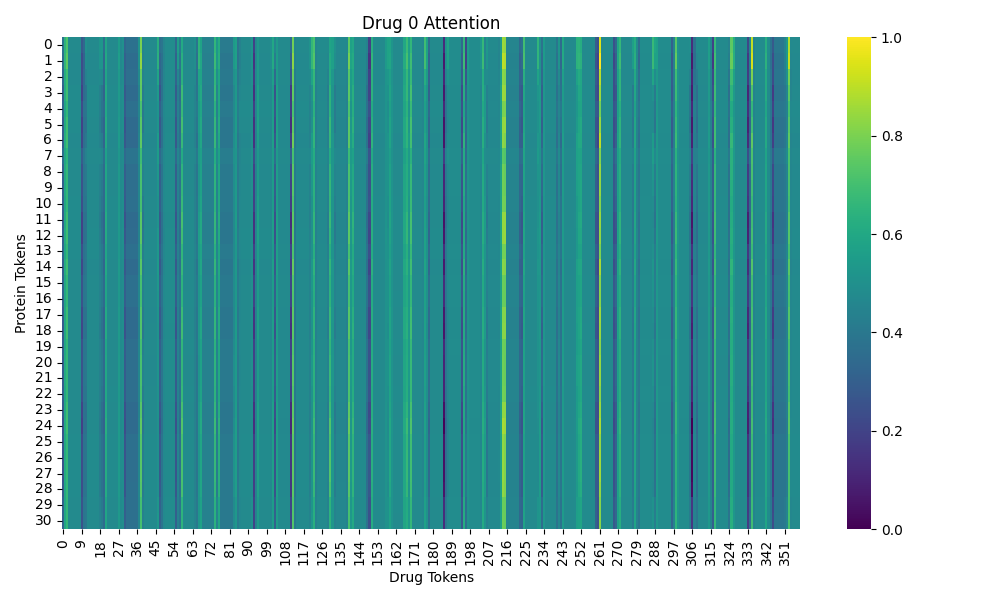

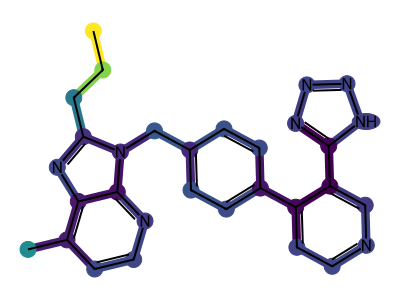

In [ ]:
from IPython.display import Image, SVG

attention_plot = Image(att_path)
molecular_img = SVG(mol_path)
display(attention_plot)
display(molecular_img)

The output images are saved in the `visualization` directory. The attention map shows how much each drug token attends to each protein token, while the molecule image highlights the atoms based on their attention values.

## Extension Tasks

### Task 1

To use the BindingDB dataset, modify the relevant line in the Configuration section of Step 0 as shown below.

```python
cfg.DATA.DATASET = "bindingdb"
```

Reload the dataset and re-run training and testing.

> Tip: See if the model struggles more or less with the new dataset. It can reveal how generalisable DrugBAN is.


### Task 2

Turn off domain adaptation by updating the config file and re-running training and testing.

Replace `configs/DA_cross_domain.yaml` with `configs/non_DA_cross_domain.yaml` in the Configuration section of Step 0 as shown below.

```python
cfg.merge_from_file("configs/non_DA_cross_domain.yaml")
```
>Tip: Compare the results with and without domain adaptation to see how it affects model performance.